# Variational AutoEncoder

Useful References:
- VAE original paper: https://arxiv.org/pdf/1312.6114
- Better VAE tutorial: https://arxiv.org/pdf/1606.05908

In [1]:
import torch
import torchvision # Add this import line
import joblib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from collections import defaultdict

Matplotlib is building the font cache; this may take a moment.


In [3]:
class GELU(torch.nn.Module):
    def forward(self, input):
        return F.gelu(input)

## 1. Data Preprocessing

We already worked on data preprocessing and feature engineering. Great Job!

Data is alreayd prepared for this project and all we need is load the data, understand basic data structure and get ready for model training. 

In [4]:
# TODO
# Load Data...
import pandas as pd

# William/SB28_VAE/SB28_VAE_data/VAE_grouped_data.csv

# You will need to double check column types
# Of course need Standarlize and Normalize before send to model
# Train test split
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('William/SB28_VAE/SB28_VAE_data/VAE_grouped_data.csv')
print(df.head())

# numeric_cols = df.select_dtypes(include='number').columns
# scaler = MinMaxScaler()
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


        loginname        date  bet_max  payout_max  profit_mean  \
0  A0201klc082828  2024-03-26      0.5         2.7    -0.148571   
1  A0401m02261004  2024-03-23      5.0        22.0    -2.693182   
2      A04cskscxt  2024-03-01      0.5        18.0     0.473750   
3    A04m02261004  2024-03-01      5.0        60.0    -2.666667   
4    A04m02261004  2024-03-03     15.0       200.0     1.090779   

   profit_median  profit_max  bet_median  payout_mean  delta_bet_p25  ...  \
0           -0.4         2.2         0.5     0.351429            0.0  ...   
1           -5.0        17.0         5.0     2.306818            0.0  ...   
2           -0.5        18.0         0.5     0.911250            0.0  ...   
3           -5.0        55.0         5.0     1.916667            0.0  ...   
4           -5.0       195.0         5.0     7.888076            0.0  ...   

   win_streak_mean  delta_profit_max  delta_t_min  delta_t_p25  \
0         0.314286               2.0          0.0          3.0   
1 

In [5]:
df2 = df.drop(columns=['loginname', 'date'])
df3 = df2.fillna(df2.mean())
print(df3.head())

   bet_max  payout_max  profit_mean  profit_median  profit_max  bet_median  \
0      0.5         2.7    -0.148571           -0.4         2.2         0.5   
1      5.0        22.0    -2.693182           -5.0        17.0         5.0   
2      0.5        18.0     0.473750           -0.5        18.0         0.5   
3      5.0        60.0    -2.666667           -5.0        55.0         5.0   
4     15.0       200.0     1.090779           -5.0       195.0         5.0   

   payout_mean  delta_bet_p25  profit_p75  delta_bet_p75  ...  \
0     0.351429            0.0        -0.1            0.0  ...   
1     2.306818            0.0        -3.0            0.0  ...   
2     0.911250            0.0         0.0            0.0  ...   
3     1.916667            0.0        -2.5            0.0  ...   
4     7.888076            0.0         0.0            0.0  ...   

   win_streak_mean  delta_profit_max  delta_t_min  delta_t_p25  \
0         0.314286               2.0          0.0          3.0   
1       

In [6]:
from sklearn.preprocessing import RobustScaler

# 2) Identify numeric columns
numeric_cols = df3.select_dtypes(include='number').columns

# 3) Compute IQR bounds
Q1 = df3[numeric_cols].quantile(0.05)
Q3 = df3[numeric_cols].quantile(0.95) # try changing the percentile range for measurement
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
scaler = RobustScaler(quantile_range=(5.0, 95.0))
df3_scaled = df3.copy()
df3_scaled[numeric_cols] = scaler.fit_transform(df3_scaled[numeric_cols])

# 4) Flag outliers (any column beyond its bounds)
mask_outliers = ((df3_scaled[numeric_cols] < lower) | (df3_scaled[numeric_cols] > upper)).any(axis=1)

# 5) See how many
print(f"Total rows: {len(df3_scaled)}")
print(f"Outliers detected: {mask_outliers.sum()} ({100*mask_outliers.mean():.2f}%)")

# 6) View a few outlier rows
display(df3_scaled[mask_outliers].head())

# 7) Drop them if you choose
df3 = df3_scaled[~mask_outliers].reset_index(drop=True)
print(f"After dropping, rows = {len(df3)}")

Total rows: 678192
Outliers detected: 79728 (11.76%)


,bet_max,payout_max,profit_mean,profit_median,profit_max,bet_median,payout_mean,delta_bet_p25,profit_p75,delta_bet_p75,...,win_streak_mean,delta_profit_max,delta_t_min,delta_t_p25,lose_streak_min,streak_median,basepoint_max,delta_profit_min,midnight_count,basepoint_min
10,68.896552,61.139806,-24.549834,-66.533333,62.667662,66.533333,45.564794,0.0,-49.850,0.0,...,0.064192,58.737629,0.5,0.333333,0.0,0.712766,23.995710,-65.735908,1.452736,0.140677
15,-0.034483,-0.023301,0.048796,0.066667,-0.019403,-0.066667,-0.045217,0.0,0.125,0.5,...,-0.302326,-0.025773,0.0,-0.333333,0.2,-0.053191,-0.011527,0.024008,0.000000,-0.001416
19,-0.034483,-0.025243,0.011534,0.066667,-0.021393,-0.066667,-0.068768,0.5,0.025,0.5,...,-0.302326,-0.027835,0.0,-0.333333,0.2,-0.053191,-0.011527,0.023486,0.000000,-0.001288
27,-0.034483,-0.025243,0.011534,0.066667,-0.021393,-0.066667,-0.068768,0.5,0.025,0.5,...,-0.302326,-0.027835,0.0,-0.333333,0.2,-0.053191,-0.011550,0.023486,0.000000,-0.001352
39,-0.034483,-0.025243,0.011534,0.066667,-0.021393,-0.066667,-0.068768,0.5,0.025,0.5,...,-0.302326,-0.027835,0.0,-0.333333,0.2,-0.053191,-0.011527,0.023486,0.000000,-0.001288


After dropping, rows = 598464


In [7]:
# Assume 'df3' is your final, cleaned DataFrame before scaling
# Temporarily drop the target column to create the feature set 'X'
X = df3.drop(columns=['payout_mean'])
# Use the dropped column as the target 'y'
y = df3['payout_mean']

In [8]:
# Create and train the model
# n_jobs=-1 uses all available CPU cores to speed up training
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to view the importances with their feature names
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display the top 10 most important features
print(feature_importance_df.head(15))

             feature  importance
14    account_stddev    0.422185
12  delta_profit_p25    0.187390
2        profit_mean    0.156877
1         payout_max    0.136838
10          bet_mean    0.055669
4         profit_max    0.017995
3      profit_median    0.013816
5         bet_median    0.004936
15     delta_bet_min    0.000887
13     delta_bet_max    0.000854
25   win_streak_mean    0.000650
32  delta_profit_min    0.000312
0            bet_max    0.000173
7         profit_p75    0.000171
26  delta_profit_max    0.000156


In [9]:
# Decide how many features to keep, e.g., the top 20
num_features_to_keep = 15
top_features = feature_importance_df['feature'].head(num_features_to_keep).tolist()

# Create a new DataFrame with only the most important features
df3 = df3[top_features]

print(f"\nNew dataset shape with selected features: {df3.shape}")

# Now, use this 'df_selected' DataFrame as the input for your entire
# VAE training pipeline (scaling, creating the dataset, training, etc.).


New dataset shape with selected features: (598464, 15)


In [10]:
class TabularDatasetWithNoise(Dataset):
    def __init__(self, features, noise_level=0.01, is_train=True):
        """
        Args:
            features (pd.DataFrame or np.array): The input features for the model.
            noise_level (float): The standard deviation of the Gaussian noise to add.
            is_train (bool): Flag to determine whether to apply augmentation.
        """
        # Convert dataframe to numpy array for efficiency
        self.features = features.values if isinstance(features, pd.DataFrame) else features
        self.noise_level = noise_level
        self.is_train = is_train

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Get a single row of data and convert to a tensor
        x = torch.tensor(self.features[idx], dtype=torch.float32)

        # Only add noise to the training data
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x.shape) * self.noise_level
            x = x + noise
            
        return x, # Return as a tuple

In [11]:

class GradientMonitor:
    """
    Gradient monitor class for tracking gradients during VAE training
    """
    
    def __init__(self, model, hook_layers=None, track_norms=True, track_distributions=True):
        """
        Initialize gradient monitor
        
        Args:
            model: VAE model instance
            hook_layers: List of layer names to hook (None for all layers)
            track_norms: Whether to track gradient norms
            track_distributions: Whether to track gradient distributions
        """
        self.model = model
        self.hook_layers = hook_layers
        self.track_norms = track_norms
        self.track_distributions = track_distributions
        
        # Storage for gradient statistics
        self.gradient_norms = defaultdict(list)
        self.gradient_stats = defaultdict(lambda: {'mean': [], 'std': [], 'max': [], 'min': []})
        self.gradient_histograms = defaultdict(list)
        
        # Hook handles for cleanup
        self.hook_handles = []
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        """Register backward hooks on specified layers"""
        
        def create_hook(name):
            def hook_fn(module, grad_input, grad_output):
                if grad_output[0] is not None:
                    grad = grad_output[0]
                    
                    if self.track_norms:
                        # Calculate gradient norm
                        grad_norm = torch.norm(grad).item()
                        self.gradient_norms[name].append(grad_norm)
                    
                    if self.track_distributions:
                        # Calculate gradient statistics
                        grad_flat = grad.flatten()
                        self.gradient_stats[name]['mean'].append(torch.mean(grad_flat).item())
                        self.gradient_stats[name]['std'].append(torch.std(grad_flat).item())
                        self.gradient_stats[name]['max'].append(torch.max(grad_flat).item())
                        self.gradient_stats[name]['min'].append(torch.min(grad_flat).item())
                        
                        # Store histogram data (sample to avoid memory issues)
                        if len(grad_flat) > 1000:
                            sampled_grad = grad_flat[torch.randperm(len(grad_flat))[:1000]]
                        else:
                            sampled_grad = grad_flat
                        self.gradient_histograms[name].append(sampled_grad.detach().cpu().numpy())
            
            return hook_fn
        
        # Register hooks on specified layers or all layers
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                if self.hook_layers is None or name in self.hook_layers:
                    handle = module.register_backward_hook(create_hook(name))
                    self.hook_handles.append(handle)
                    print(f"Registered hook on layer: {name}")
    
    def clear_statistics(self):
        """Clear all stored gradient statistics"""
        self.gradient_norms.clear()
        self.gradient_stats.clear()
        self.gradient_histograms.clear()
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles.clear()
    
    def get_gradient_norms(self, layer_name=None):
        """Get gradient norms for a specific layer or all layers"""
        if layer_name:
            return self.gradient_norms.get(layer_name, [])
        return dict(self.gradient_norms)
    
    def get_gradient_stats(self, layer_name=None):
        """Get gradient statistics for a specific layer or all layers"""
        if layer_name:
            return self.gradient_stats.get(layer_name, {})
        return dict(self.gradient_stats)
    
    def plot_gradient_norms(self, figsize=(12, 8), show_recent=None):
        """Plot gradient norms over training steps"""
        if not self.gradient_norms:
            print("No gradient norm data available")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        layer_names = list(self.gradient_norms.keys())
        
        for i, layer_name in enumerate(layer_names[:4]):  # Show first 4 layers
            if i >= len(axes):
                break
                
            norms = self.gradient_norms[layer_name]
            if show_recent:
                norms = norms[-show_recent:]
            
            axes[i].plot(norms, alpha=0.7)
            axes[i].set_title(f'Gradient Norms: {layer_name}')
            axes[i].set_xlabel('Training Step')
            axes[i].set_ylabel('Gradient Norm')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_yscale('log')  # Log scale for better visualization
        
        # Hide unused subplots
        for i in range(len(layer_names), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def plot_gradient_distributions(self, layer_name, figsize=(12, 4)):
        """Plot gradient distribution evolution for a specific layer"""
        if layer_name not in self.gradient_histograms:
            print(f"No histogram data for layer: {layer_name}")
            return
        
        histograms = self.gradient_histograms[layer_name]
        if len(histograms) < 2:
            print("Not enough data for distribution plot")
            return
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Show first, middle, and last distributions
        indices = [0, len(histograms)//2, -1]
        labels = ['Early Training', 'Mid Training', 'Late Training']
        
        for i, (idx, label) in enumerate(zip(indices, labels)):
            axes[i].hist(histograms[idx], bins=50, alpha=0.7, density=True)
            axes[i].set_title(f'{label}\n{layer_name}')
            axes[i].set_xlabel('Gradient Value')
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def detect_gradient_issues(self, threshold_vanishing=1e-6, threshold_exploding=10.0):
        """Detect gradient vanishing or exploding issues"""
        issues = {}
        
        for layer_name, norms in self.gradient_norms.items():
            if not norms:
                continue
                
            recent_norms = norms[-10:] if len(norms) >= 10 else norms
            avg_norm = np.mean(recent_norms)
            
            if avg_norm < threshold_vanishing:
                issues[layer_name] = f"Vanishing gradients (avg norm: {avg_norm:.2e})"
            elif avg_norm > threshold_exploding:
                issues[layer_name] = f"Exploding gradients (avg norm: {avg_norm:.2e})"
        
        return issues
    
    def print_gradient_summary(self):
        """Print summary of gradient statistics"""
        print("Gradient Monitor Summary")
        print(f"Tracking {len(self.gradient_norms)} layers\n")
        
        for layer_name in self.gradient_norms.keys():
            norms = self.gradient_norms[layer_name]
            if norms:
                avg_norm = np.mean(norms)
                min_norm = np.min(norms)
                max_norm = np.max(norms)
                
                # Classify gradient status
                if avg_norm < 1e-6:
                    status = "VANISH"
                elif avg_norm > 10:
                    status = "EXPLODE"
                else:
                    status = "NORMAL"
                
                print(f"{layer_name:<15} | {status:<7} | Avg: {avg_norm:.4f} | Range: [{min_norm:.4f}, {max_norm:.4f}]")
        
        # Check for issues
        issues = self.detect_gradient_issues()
        if issues:
            print(f"\nFound {len(issues)} potential issues:")
            for layer, issue in issues.items():
                print(f"   {layer}: {issue}")
        else:
            print("\nAll gradients are normal")


## 2. Model Architecture

VAE includes two main parts: Encoder and Decoder
Encoder encodes input data into mean vector and var vector. Both send to latent vector, and then Decoder generates output.

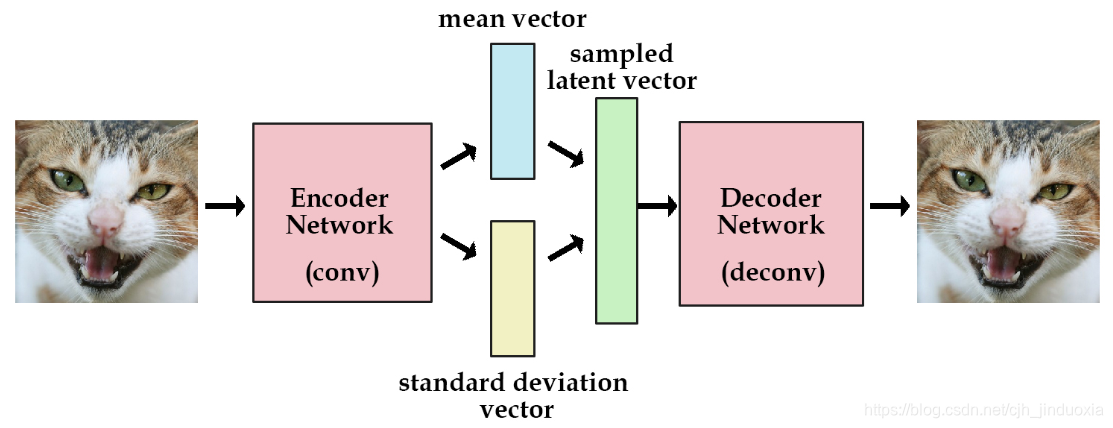

### Encoder

In [12]:
class Encoder(nn.Module):
    """
    VAE编码器：将输入数据x映射到潜在空间的分布参数μ和log_var
    
    架构说明：
    - 特征提取层：多层全连接网络，逐步降维
    - μ网络：输出潜在空间的均值参数
    - σ网络：输出潜在空间的对数方差参数
    """
    
    def __init__(self, input_dim: int, hidden_dims: List[int], latent_dim: int):
        """
        初始化编码器
        
        Args:
            input_dim: 输入数据维度
            hidden_dims: 隐藏层维度列表，如[512, 256, 128]
            latent_dim: 潜在空间维度
        """
        super(Encoder, self).__init__()
        
        # 构建特征提取层
        self.feature_extractor = self._build_feature_extractor(input_dim, hidden_dims)
        
        # 获取特征提取层的输出维度
        feature_dim = hidden_dims[-1] if hidden_dims else input_dim
        
        # ==================== 🔍 学生完成部分 1 ====================
        # TODO: 初始化均值网络（mu_net）和对数方差网络（logvar_net）
        # 提示：
        # 1. 均值网络：从feature_dim映射到latent_dim
        # 2. 对数方差网络：从feature_dim映射到latent_dim
        # 3. 通常使用简单的线性层即可
        # 4. 均值网络输出可以是任意实数
        # 5. 对数方差网络输出log_variance以保证数值稳定性
        
        self.mu_net = nn.Linear(feature_dim, latent_dim)    # 请替换为正确的网络结构
        self.logvar_net = nn.Linear(feature_dim, latent_dim)  # 请替换为正确的网络结构
        
        # =========================================================
#         # right after you compute feature_dim = …
#     # 1) μ-head: map from feature_dim → latent_dim  
#     self.mu_net = nn.Linear(feature_dim, latent_dim)  

#     # 2) log σ²-head: map from feature_dim → latent_dim  
#     self.logvar_net = nn.Linear(feature_dim, latent_dim)

        
# #         If u wanted a tiny MLP instead of single linear layer
#     self.mu_net = nn.Sequential(
#         nn.Linear(feature_dim, hidden_dim),
#         nn.ReLU(inplace=True),
#         nn.Linear(hidden_dim, latent_dim),
#     )

# self.logvar_net = nn.Sequential(
#     nn.Linear(feature_dim, hidden_dim),
#     nn.ReLU(inplace=True),
#     nn.Linear(hidden_dim, latent_dim),
# )

# # then in the forward we do something like:
#     h = self.feature_extractor(x)           # → [batch, feature_dim]
#     mu      = self.mu_net(h)                # → [batch, latent_dim]
#     log_var = self.logvar_net(h)            # → [batch, latent_dim]
        
        ###
        # apply Kaiming init to all linear layers
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            if m in (self.mu_net, self.logvar_net):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            else:
                nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
#                 nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
#             nn.init.zeros_(m.bias)
#             nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
#             nn.init.zeros_(m.bias)


        
        
        # =========================================================
    
    def _build_feature_extractor(self, input_dim: int, hidden_dims: List[int]) -> nn.Module:
        """构建特征提取层"""
        layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                GELU(), #GeLU?
                nn.Dropout(0.30)
            ])
            current_dim = hidden_dim
        
        return nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        前向传播
        
        Args:
            x: 输入数据 [batch_size, input_dim]
            
        Returns:
            mu: 均值参数 [batch_size, latent_dim]
            log_var: 对数方差参数 [batch_size, latent_dim]
        """
        # 特征提取
        features = self.feature_extractor(x)
        
        # ==================== 🔍 学生完成部分 2 ====================
        # TODO: 计算均值和对数方差
        # 提示：
        # 1. 将特征features输入到对应的网络中
        # 2. 注意检查输出的维度是否正确
        
        mu = self.mu_net(features)        # 请替换为正确的计算
        log_var = self.logvar_net(features)   # 请替换为正确的计算
        
        # =========================================================
        
        return mu, log_var

### Decoder

In [13]:
class Decoder(nn.Module):
    """
    VAE解码器：将潜在变量z重建为原始数据
    
    架构说明：
    - 潜在空间映射：将低维潜在变量映射到高维特征空间
    - 重建网络：多层全连接网络，逐步升维
    - 输出层：根据数据类型选择合适的激活函数
    """
    
    def __init__(self, latent_dim: int, hidden_dims: List[int], output_dim: int, 
                 output_activation: str = 'none'):
        """
        初始化解码器
        
        Args:
            latent_dim: 潜在空间维度
            hidden_dims: 隐藏层维度列表（通常与编码器相反）
            output_dim: 输出数据维度
            output_activation: 输出激活函数 ('sigmoid', 'tanh', 'none')
        """
        super(Decoder, self).__init__()
        
        # ==================== 🔍 学生完成部分 3 ====================
        # TODO: 构建从潜在空间到第一个隐藏层的映射
        # 提示：
        # 1. 这是一个线性层，将latent_dim映射到hidden_dims[0]
        # 2. 输入维度：latent_dim
        # 3. 输出维度：hidden_dims[0]（第一个隐藏层的维度）
        # 4. 使用 nn.Linear(input_dim, output_dim)
        
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dims[0])  # 请替换为正确的网络结构
        
        # =========================================================
        
        # 构建重建网络
        self.reconstruction_net = self._build_reconstruction_net(hidden_dims, output_dim)
        
        # 输出激活函数
        self.output_activation = output_activation
    
    def _build_reconstruction_net(self, hidden_dims: List[int], output_dim: int) -> nn.Module:
        """构建重建网络"""
        layers = []
        
        # 隐藏层
        for i in range(len(hidden_dims) - 1):
            layers.extend([
                nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                nn.BatchNorm1d(hidden_dims[i + 1]),
                GELU(),
                nn.Dropout(0.30)
            ])
        
        # 输出层
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        return nn.Sequential(*layers)
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        Args:
            z: 潜在变量 [batch_size, latent_dim]
            
        Returns:
            x_recon: 重建数据 [batch_size, output_dim]
        """
        # ==================== 🔍 学生完成部分 4 ====================
        # TODO: 从潜在空间映射到隐藏层
        # 提示：
        # 1. 先通过latent_to_hidden映射：self.latent_to_hidden(z)
        # 2. 再添加激活函数，通常使用ReLU：F.relu(...)
        # 3. 完整形式：hidden = F.relu(self.latent_to_hidden(z))
        
        hidden = F.gelu(self.latent_to_hidden(z))  # 请替换为正确的计算
        
        # =========================================================
        
        # 通过重建网络
        x_recon = self.reconstruction_net(hidden)
        
        # ==================== 🔍 学生完成部分 5 ====================
        # TODO: 根据output_activation应用输出激活函数
        # 提示：
        # 1. 'sigmoid': 将输出压缩到(0,1)范围，使用torch.sigmoid(x_recon)
        # 2. 'tanh': 将输出压缩到(-1,1)范围，使用torch.tanh(x_recon)
        # 3. 'none': 不使用激活函数，直接输出
        # 4. 根据数据范围选择合适的激活函数
        
        if self.output_activation == 'sigmoid':
            x_recon = torch.sigmoid(x_recon)  # 请替换为正确的激活函数
        elif self.output_activation == 'tanh':
            x_recon = torch.tanh(x_recon)  # 请替换为正确的激活函数
        # 'none'情况下不需要激活函数
        
        # =========================================================
        
        return x_recon

### VAE model

In [14]:
class VAE(nn.Module):
    """
    变分自编码器 (Variational Autoencoder)
    
    组件说明：
    - Encoder: 将输入映射到潜在空间的分布参数
    - Decoder: 将潜在变量重建为原始数据
    - Reparameterization: 重参数化技巧，实现可微分采样
    """
    
    def __init__(self, input_dim: int, hidden_dims: List[int], latent_dim: int,
                 output_activation: str = 'none'):
        """
        初始化VAE模型
        
        Args:
            input_dim: 输入数据维度
            hidden_dims: 隐藏层维度列表
            latent_dim: 潜在空间维度
            output_activation: 输出激活函数类型
        """
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # 初始化编码器和解码器
        self.encoder = Encoder(input_dim, hidden_dims, latent_dim)
        
        # 解码器的隐藏层维度与编码器相反
        decoder_hidden_dims = hidden_dims[::-1]
        self.decoder = Decoder(latent_dim, decoder_hidden_dims, input_dim, output_activation)
    
    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        重参数化技巧 (Reparameterization Trick)
        
        核心思想：
        - 不能直接从N(μ, σ²)采样，因为采样过程不可微分
        - 解决方案：z = μ + σ * ε，其中ε ~ N(0, I)
        - 这样梯度可以通过μ和σ进行反向传播
        
        Args:
            mu: 均值参数 [batch_size, latent_dim]
            log_var: 对数方差参数 [batch_size, latent_dim]
            
        Returns:
            z: 采样的潜在变量 [batch_size, latent_dim]
        """
        # ==================== 🔍 学生完成部分 6 ====================
        # TODO: 实现重参数化采样
        # 提示：
        # 1. 从log_var计算标准差：std = torch.exp(0.5 * log_var)
        # 2. 生成标准正态分布噪声：eps = torch.randn_like(mu)
        # 3. 应用重参数化公式：z = mu + std * eps
        # 4. 为什么用0.5？因为std = sqrt(var) = exp(0.5 * log_var)
        
        std = torch.exp(0.5 * log_var)      # 请替换为正确的计算：从log_var计算std
        
        ### clip log_var between -10 ~ 10
        
        eps = torch.randn_like(mu)     # 请替换为正确的计算：生成标准正态分布噪声
        z = mu + std * eps       # 请替换为正确的计算：应用重参数化公式
        
        # =========================================================
        
        return z
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        前向传播
        
        Args:
            x: 输入数据 [batch_size, input_dim]
            
        Returns:
            x_recon: 重建数据 [batch_size, input_dim]
            mu: 均值参数 [batch_size, latent_dim]
            log_var: 对数方差参数 [batch_size, latent_dim]
        """
        # ==================== 🔍 学生完成部分 7 ====================
        # TODO: 实现完整的前向传播过程
        # 提示：
        # 1. 编码：mu, log_var = self.encoder(x)
        # 2. 重参数化：z = self.reparameterize(mu, log_var)
        # 3. 解码：x_recon = self.decoder(z)
        # 4. 返回重建数据和分布参数，用于损失计算
        
        # 第1步：编码
        mu, log_var = self.encoder(x)  # 请替换为正确的计算
        
        log_var = torch.clamp(log_var, min=-10, max=10)
        # 第2步：重参数化采样
        z = self.reparameterize(mu, log_var)  # 请替换为正确的计算
        
        # 第3步：解码重建
        x_recon = self.decoder(z)  # 请替换为正确的计算
        
        # =========================================================
        
        return x_recon, mu, log_var
    
    def sample(self, num_samples: int, device: torch.device) -> torch.Tensor:
        """
        从先验分布采样生成新数据
        
        Args:
            num_samples: 生成样本数量
            device: 设备
            
        Returns:
            generated_samples: 生成的样本 [num_samples, input_dim]
        """
        # ==================== 🔍 学生完成部分 8 ====================
        # TODO: 实现数据生成功能
        # 提示：
        # 1. 从标准正态分布采样：z = torch.randn(num_samples, self.latent_dim).to(device)
        # 2. 通过解码器生成：generated_samples = self.decoder(z)
        # 3. 注意要在torch.no_grad()下执行以节省内存
        
        with torch.no_grad():
            # 从先验分布采样潜在变量
            z = torch.randn(num_samples, self.latent_dim, device=device)  # 请替换为正确的计算
            
            # 通过解码器生成样本
            generated_samples = self.decoder(z)  # 请替换为正确的计算
            
        # =========================================================
            
        return generated_samples

## 3. Loss Function
 

In [15]:
class VAELoss(nn.Module):
    """
    VAE损失函数
    
    组成部分：
    1. 重建损失 (Reconstruction Loss): 衡量重建质量
    2. KL散度损失 (KL Divergence Loss): 正则化项，约束后验分布接近先验分布
    3. β参数: 平衡两种损失的权重
    """
    
    def __init__(self, reconstruction_loss: str = 'mse', beta: float = 1.0):
        """
        初始化损失函数
        
        Args:
            reconstruction_loss: 重建损失类型 ('mse', 'bce')
            beta: KL散度损失的权重系数
        """
        super(VAELoss, self).__init__()
        self.beta = beta
        self.reconstruction_loss = reconstruction_loss
    
    def reconstruction_loss_fn(self, x_recon: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        计算重建损失
        
        Args:
            x_recon: 重建数据 [batch_size, input_dim]
            x: 原始数据 [batch_size, input_dim]
            
        Returns:
            recon_loss: 重建损失
        """
        if self.reconstruction_loss == 'mse':
            return F.mse_loss(x_recon, x, reduction='mean')
        elif self.reconstruction_loss == 'bce':
            return F.binary_cross_entropy(x_recon, x, reduction='mean')
        else:
            raise ValueError(f"Unsupported reconstruction loss: {self.reconstruction_loss}")
    
    def kl_divergence_loss(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """
        计算KL散度损失
        
        KL散度公式：
        KL(q(z|x) || p(z)) = -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
        
        其中：
        - q(z|x): 后验分布 N(μ, σ²)
        - p(z): 先验分布 N(0, I)
        
        Args:
            mu: 均值参数 [batch_size, latent_dim]
            log_var: 对数方差参数 [batch_size, latent_dim]
            
        Returns:
            kl_loss: KL散度损失
        """
        # ==================== 🔍 学生完成部分 9 ====================
        # TODO: 实现KL散度损失计算
        # 提示：
        # 1. KL散度公式：KL = -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
        # 2. 使用torch.sum()对所有维度求和
        # 3. mu^2 可以写成 mu.pow(2) 或 mu**2
        # 4. exp(log_var) 就是 torch.exp(log_var)
        # 5. 公式推导：比较q(z|x)=N(μ,σ²) 和 p(z)=N(0,I)
        # element-wise formula
#         kl_element = 1 + log_var - mu.pow(2) - log_var.exp()
#         kl_loss = -0.5 * torch.sum(kl_element, dim=1)  # 请替换为正确的计算
        
    
        # Compute KL divergence: KL = -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
        kl_element = 1 + log_var - mu.pow(2) - log_var.exp()
        kl_loss = -0.5 * torch.sum(kl_element)  # Apply -0.5 to the sum
        return kl_loss
        
        # =========================================================
        
        return kl_loss
    
    def forward(self, x_recon: torch.Tensor, x: torch.Tensor, 
                mu: torch.Tensor, log_var: torch.Tensor, beta: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        计算总损失
        
        Args:
            x_recon: 重建数据
            x: 原始数据
            mu: 均值参数
            log_var: 对数方差参数
            
        Returns:
            total_loss: 总损失
            recon_loss: 重建损失
            kl_loss: KL散度损失
        """
        # ==================== 🔍 学生完成部分 10 ===================
        # TODO: 计算各个损失组件
        # 提示：
        # 1. 重建损失：recon_loss = self.reconstruction_loss_fn(x_recon, x)
        # 2. KL散度损失：kl_loss = self.kl_divergence_loss(mu, log_var)
        # 3. 总损失：total_loss = recon_loss + self.beta * kl_loss
        # 4. beta参数用于平衡重建质量和正则化强度
        
        recon_loss = self.reconstruction_loss_fn(x_recon, x)  # 请替换为正确的计算
        kl_loss = self.kl_divergence_loss(mu, log_var)     # 请替换为正确的计算
        
        # 总损失 = 重建损失 + β * KL散度损失
        total_loss = recon_loss + self.beta * kl_loss  # 请替换为正确的计算
        
        # =========================================================
        
        return total_loss, recon_loss, kl_loss


## 4. Train Model

In [16]:
class VAETrainer:
    """
    VAE训练器
    
    功能：
    - 管理训练循环
    - 记录损失历史
    - 提供评估和可视化接口
    """
    
    def __init__(self, model: VAE, loss_fn: VAELoss, optimizer: torch.optim.Optimizer,
                 scheduler, device: torch.device, enable_gradient_monitoring=False):
        """
        初始化训练器
        
        Args:
            model: VAE模型
            loss_fn: 损失函数
            optimizer: 优化器
            device: 设备
        """
        self.model = model
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Total: {total_params:,}, Trainable: {trainable_params:,}")
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        
        # 损失历史记录
        self.train_losses = {'total': [], 'recon': [], 'kl': []}
        self.val_losses = {'total': [], 'recon': [], 'kl': []}
        
        self.enable_gradient_monitoring = enable_gradient_monitoring
        if enable_gradient_monitoring:
            self.grad_monitor = GradientMonitor(
                model, 
                hook_layers=None,  # Specific layers
                track_norms=True,
                track_distributions=True
            )
        else:
            self.grad_monitor = None
    
    
    def train_epoch(self, train_loader: DataLoader, beta) -> Tuple[float, float, float]:
        """
        训练一个epoch
        
        Args:
            train_loader: 训练数据加载器
            
        Returns:
            平均总损失, 平均重建损失, 平均KL损失
        """
        self.model.train()
        total_loss = 0.0
        total_recon_loss = 0.0
        total_kl_loss = 0.0
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(self.device)
            
            # ==================== 🔍 学生完成部分 11 ===================
            # TODO: 实现训练步骤
            # 提示：
            # 1. 清零梯度：self.optimizer.zero_grad()
            # 2. 前向传播：x_recon, mu, log_var = self.model(data)
            # 3. 计算损失：loss, recon_loss, kl_loss = self.loss_fn(x_recon, data, mu, log_var)
            # 4. 反向传播：loss.backward()
            # 5. 更新参数：self.optimizer.step()
            
            # 第1步：清零梯度
            self.optimizer.zero_grad()  # 取消注释并完善
            
            # 第2步：前向传播
            #print(data.shape)
            x_recon, mu, log_var = self.model(data) # 请替换为正确的计算
            #print(x_recon.shape, mu.shape, log_var.shape)
            
            # 第3步：计算损失
            loss, recon_loss, kl_loss = self.loss_fn(x_recon, data, mu, log_var, beta = beta)  # 请替换为正确的计算
            #print(loss.shape, recon_loss.shape, kl_loss.shape)
            if loss.dim() != 0:
                loss = loss.sum()
            #print(loss.shape, recon_loss.shape, kl_loss.shape)
            
            # 第4步：反向传播
            loss.backward()  # 取消注释
            
            torch.nn.utils.clip_grad_norm_(self.model.encoder.mu_net.parameters(),     max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(self.model.encoder.logvar_net.parameters(), max_norm=1.0)
            # optionally also clip the rest of the encoder:
            torch.nn.utils.clip_grad_norm_(self.model.encoder.parameters(),           max_norm=5.0)
            
            # 第5步：更新参数
            self.optimizer.step()  # 取消注释
            
            # 累积损失（取消下面三行的注释）
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            if self.grad_monitor is not None and batch_idx % 50 == 0:
                print(f"\n--- Batch {batch_idx} Gradients ---")
                self.grad_monitor.print_gradient_summary()
            
            # =========================================================
        
        # 计算平均损失
        num_batches = len(train_loader)
        avg_total_loss = total_loss / num_batches
        avg_recon_loss = total_recon_loss / num_batches
        avg_kl_loss = total_kl_loss / num_batches
        
        return avg_total_loss, avg_recon_loss, avg_kl_loss
    
    def validate(self, val_loader: DataLoader, beta) -> Tuple[float, float, float]:
        """
        验证模型
        
        Args:
            val_loader: 验证数据加载器
            
        Returns:
            平均总损失, 平均重建损失, 平均KL损失
        """
        self.model.eval()
        total_loss = 0.0
        total_recon_loss = 0.0
        total_kl_loss = 0.0
        
        with torch.no_grad():
            for data, in val_loader:
                data = data.to(self.device)
                
                # 前向传播
                x_recon, mu, log_var = self.model(data)
                
                # 计算损失
                loss, recon_loss, kl_loss = self.loss_fn(x_recon, data, mu, log_var, beta)
                
                # 累积损失
                total_loss += loss.item()
                total_recon_loss += recon_loss.item()
                total_kl_loss += kl_loss.item()
        
        # 计算平均损失
        num_batches = len(val_loader)
        avg_total_loss = total_loss / num_batches
        avg_recon_loss = total_recon_loss / num_batches
        avg_kl_loss = total_kl_loss / num_batches
        
        return avg_total_loss, avg_recon_loss, avg_kl_loss
    
    def train(self, train_loader: DataLoader, val_loader: DataLoader = None, 
              num_epochs: int = 100, print_every: int = 10, anneal_epochs = 50):
        """
        完整训练过程
        
        Args:
            train_loader: 训练数据加载器
            val_loader: 验证数据加载器（可选）
            num_epochs: 训练轮数
            print_every: 打印频率
        """
        print("开始训练VAE模型...")
        print("-" * 50)
        
        for epoch in range(num_epochs):
            current_beta = min(0.000005, epoch / anneal_epochs)
            # 训练
            train_total, train_recon, train_kl = self.train_epoch(train_loader, current_beta)
            
            # 记录训练损失
            self.train_losses['total'].append(train_total)
            self.train_losses['recon'].append(train_recon)
            self.train_losses['kl'].append(train_kl)
            
            # 验证（如果提供了验证集）
            if val_loader is not None:
                val_total, val_recon, val_kl = self.validate(val_loader, current_beta)
                self.val_losses['total'].append(val_total)
                self.val_losses['recon'].append(val_recon)
                self.val_losses['kl'].append(val_kl)
                self.scheduler.step(val_total)
            
            # 打印训练信息
            if (epoch + 1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}]")
                print(f"  Train Loss: {train_total:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})")
                if val_loader is not None:
                    print(f"  Val Loss:   {val_total:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})")
                print()
        
        print("训练完成！")


## 5. Eval Model performance

In [28]:
class VAEEvaluator:
    """
    VAE评估器
    
    功能：
    - 可视化训练曲线
    - 评估重建质量
    - 潜在空间可视化
    - 生成新样本
    """
    
    def __init__(self, model: VAE, device: torch.device):
        """
        初始化评估器
        
        Args:
            model: 训练好的VAE模型
            device: 设备
        """
        self.model = model
        self.device = device
    
    def plot_training_curves(self, trainer: VAETrainer, figsize: Tuple[int, int] = (15, 5)):
        """
        绘制训练曲线
        
        Args:
            trainer: 训练器实例
            figsize: 图形大小
        """
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        epochs = range(1, len(trainer.train_losses['total']) + 1)
        
        # 总损失
        axes[0].plot(epochs, trainer.train_losses['total'], 'b-', label='Train')
        if trainer.val_losses['total']:
            axes[0].plot(epochs, trainer.val_losses['total'], 'r-', label='Validation')
        axes[0].set_title('Total Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # 重建损失
        axes[1].plot(epochs, trainer.train_losses['recon'], 'b-', label='Train')
        if trainer.val_losses['recon']:
            axes[1].plot(epochs, trainer.val_losses['recon'], 'r-', label='Validation')
        axes[1].set_title('Reconstruction Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)
        
        # KL散度损失
        axes[2].plot(epochs, trainer.train_losses['kl'], 'b-', label='Train')
        if trainer.val_losses['kl']:
            axes[2].plot(epochs, trainer.val_losses['kl'], 'r-', label='Validation')
        axes[2].set_title('KL Divergence Loss')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Loss')
        axes[2].legend()
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_reconstruction(self, test_loader: DataLoader, num_samples: int = 5):
        """
        评估重建质量
        
        Args:
            test_loader: 测试数据加载器
            num_samples: 显示的样本数量
        """
        self.model.eval()
        
        with torch.no_grad():
            # 获取测试样本
            test_data = next(iter(test_loader))[0][:num_samples].to(self.device)
            
            # 重建
            x_recon, mu, log_var = self.model(test_data)
            
            # 转换为numpy数组
            original = test_data.cpu().numpy()
            reconstructed = x_recon.cpu().numpy()
            
            # 可视化
            fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
            
            for i in range(num_samples):
                # 原始数据
                axes[0, i].plot(original[i])
                axes[0, i].set_title(f'Original {i+1}')
                axes[0, i].grid(True)
                
                # 重建数据
                axes[1, i].plot(reconstructed[i])
                axes[1, i].set_title(f'Reconstructed {i+1}')
                axes[1, i].grid(True)
            
            plt.tight_layout()
            plt.show()
            
            # 计算重建误差
            mse = np.mean((original - reconstructed) ** 2)
            print(f"平均重建误差 (MSE): {mse:.6f}")
            
    # Add this method to your VAEEvaluator class
# (Run this in a new cell to patch the existing class)

    def visualize_latent_space(self, test_loader: DataLoader, max_samples: int = 1000):
        """
        可视化潜在空间（仅适用于2D潜在空间）
        
        Args:
            test_loader: 测试数据加载器
            max_samples: 最大样本数量
        """
        if self.model.latent_dim != 2:
            print("潜在空间可视化仅适用于2D潜在空间")
            return
        
        self.model.eval()
        
        latent_codes = []
        with torch.no_grad():
            for i, (data,) in enumerate(test_loader):
                if i * test_loader.batch_size >= max_samples:
                    break
                
                data = data.to(self.device)
                mu, log_var = self.model.encoder(data)
                latent_codes.append(mu.cpu().numpy())
        
        # 合并所有潜在编码
        latent_codes = np.concatenate(latent_codes, axis=0)
        
        # 绘制潜在空间分布
        plt.figure(figsize=(10, 8))
        plt.scatter(latent_codes[:, 0], latent_codes[:, 1], alpha=0.6)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('Latent Space Visualization')
        plt.grid(True)
        plt.show()
    
    def generate_samples(self, num_samples: int = 10, figsize: Tuple[int, int] = (15, 8)):
        """
        生成新样本
        
        Args:
            num_samples: 生成样本数量
            figsize: 图形大小
        """
        self.model.eval()
        
        # 生成样本
        generated_samples = self.model.sample(num_samples, self.device)
        generated_samples = generated_samples.cpu().numpy()
        
        # 可视化
        fig, axes = plt.subplots(2, 5, figsize=figsize)
        axes = axes.flatten()
        
        for i in range(num_samples):
            axes[i].plot(generated_samples[i])
            axes[i].set_title(f'Generated Sample {i+1}')
            axes[i].grid(True)
        
        plt.tight_layout()
        plt.show()


In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# from your_vae_module import VAE, VAELoss  # adjust the import path

# turn the DataFrame into a tensor
data_tensor = torch.tensor(df3.values, dtype=torch.float32)

# wrap in a Dataset and DataLoader
dataset     = TensorDataset(data_tensor)
train_loader = DataLoader(dataset, batch_size=1000, shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2.1) Create the VAE
vae = VAE(
    input_dim        = df3.shape[1],        # number of features
    hidden_dims       = [36, 16],
    latent_dim        = 4,
    output_activation= 'none'               # or 'sigmoid' / 'tanh' if appropriate
).to(device)

# 2.2) Choose your loss
loss_fn = VAELoss(
    reconstruction_loss='mse',  # 'mse' for continuous data, or 'bce' if your inputs ∈ [0,1]
    beta=0.2                    # weight of the KL term; >1 for stronger regularization
)

# 2.3) Pick an optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)

#recorded changes
# lr = 1e-6 + lr changes
# KL annealing
# addition of scheduler
# addition of dropout = 0.3
# weight decay changes
# beta changes
# reduction of epochs from 30 ~ 20
# annual epochs from 50 ~ 25
# adding Gaussian noise to dataset
# changing model complexity
# adding feature importance, changing from 20 ~ 15

In [30]:
    def evaluate_vae_reconstruction(vae_model, test_loader, device, num_samples=None):
        """
        Evaluate VAE reconstruction quality with comprehensive statistics
        """
        vae_model.eval()

        all_errors = []
        all_squared_errors = []

        with torch.no_grad():
            if num_samples is None:
                # Use entire test set
                for batch_data, in test_loader:
                    batch_data = batch_data.to(device)
                    reconstructed, _, _ = vae_model(batch_data)

                    # Calculate errors for this batch
                    batch_errors = (batch_data - reconstructed).cpu().numpy()
                    batch_squared_errors = batch_errors ** 2

                    all_errors.append(batch_errors.flatten())
                    all_squared_errors.append(batch_squared_errors.flatten())
            else:
                # Use specific number of samples
                test_data = next(iter(test_loader))[0][:num_samples].to(device)
                reconstructed, _, _ = vae_model(test_data)

                batch_errors = (test_data - reconstructed).cpu().numpy()
                batch_squared_errors = batch_errors ** 2

                all_errors.append(batch_errors.flatten())
                all_squared_errors.append(batch_squared_errors.flatten())

        # Concatenate all errors
        all_errors = np.concatenate(all_errors)
        all_squared_errors = np.concatenate(all_squared_errors)

        # Calculate statistics
        mse = np.mean(all_squared_errors)
        mae = np.mean(np.abs(all_errors))
        rmse = np.sqrt(mse)
        std_error = np.std(all_errors)
        std_squared_error = np.std(all_squared_errors)

        # Additional statistics
        min_error = np.min(all_errors)
        max_error = np.max(all_errors)
        median_error = np.median(all_errors)

        stats = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'std_error': std_error,
            'std_squared_error': std_squared_error,
            'min_error': min_error,
            'max_error': max_error,
            'median_error': median_error,
            'num_samples': len(all_errors)
        }

        # Print results
        print("=== Reconstruction Error Statistics ===")
        print(f"MSE (Mean Squared Error): {mse:.6f}")
        print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
        print(f"MAE (Mean Absolute Error): {mae:.6f}")
        print(f"Std of Errors: {std_error:.6f}")
        print(f"Std of Squared Errors: {std_squared_error:.6f}")
        print(f"Min Error: {min_error:.6f}")
        print(f"Max Error: {max_error:.6f}")
        print(f"Median Error: {median_error:.6f}")
        print(f"Total samples evaluated: {len(all_errors)}")

        return stats

    # Now call it with your VAE model explicitly
    stats = evaluate_vae_reconstruction(vae, val_loader, device)

    print(f"\nKey results:")
    print(f"MSE: {stats['mse']:.6f}")
    print(f"Standard deviation of errors: {stats['std_error']:.6f}")

    def calculate_per_sample_reconstruction_error(vae_model, test_loader, device, num_samples=10):
        """
        Calculate MSE and std for individual samples

        Args:
            vae_model: Trained VAE model
            test_loader: DataLoader with test data
            device: Device to run evaluation on
            num_samples: Number of samples to evaluate

        Returns:
            tuple: (per_sample_mse, per_sample_std, overall_stats)
        """
        vae_model.eval()

        with torch.no_grad():
            test_data = next(iter(test_loader))[0][:num_samples].to(device)
            reconstructed, _, _ = vae_model(test_data)

            # Move to CPU for numpy operations
            original = test_data.cpu().numpy()
            recon = reconstructed.cpu().numpy()

            # Calculate per-sample statistics
            per_sample_mse = []
            per_sample_std = []

            for i in range(num_samples):
                sample_errors = original[i] - recon[i]
                sample_mse = np.mean(sample_errors ** 2)
                sample_std = np.std(sample_errors)

                per_sample_mse.append(sample_mse)
                per_sample_std.append(sample_std)

            per_sample_mse = np.array(per_sample_mse)
            per_sample_std = np.array(per_sample_std)

            # Overall statistics
            overall_mse = np.mean(per_sample_mse)
            overall_std = np.mean(per_sample_std)

            print("=== Per-Sample Reconstruction Error Statistics ===")
            print(f"Average MSE across samples: {overall_mse:.6f} ± {np.std(per_sample_mse):.6f}")
            print(f"Average Std across samples: {overall_std:.6f} ± {np.std(per_sample_std):.6f}")

            print("\nPer-sample breakdown:")
            for i in range(num_samples):
                print(f"Sample {i+1}: MSE={per_sample_mse[i]:.6f}, Std={per_sample_std[i]:.6f}")

            return per_sample_mse, per_sample_std, {
                'overall_mse': overall_mse,
                'overall_std': overall_std,
                'mse_std': np.std(per_sample_mse),
                'std_std': np.std(per_sample_std)
            }

=== Reconstruction Error Statistics ===
MSE (Mean Squared Error): 0.208324
RMSE (Root Mean Squared Error): 0.456426
MAE (Mean Absolute Error): 0.206188
Std of Errors: 0.456424
Std of Squared Errors: 5.058550
Min Error: -66.637497
Max Error: 21.695789
Median Error: -0.058366
Total samples evaluated: 1795395

Key results:
MSE: 0.208324
Standard deviation of errors: 0.456424


In [20]:
# making noise level smaller dont work at all, reverting from 0.00005 back to 0.005

# change beta from 0.005 to 0.00005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 80/20 split
# n = len(dataset)
# train_ds, val_ds = random_split(dataset, [int(0.8*n), n - int(0.8*n)],
#                                  generator=torch.Generator().manual_seed(42))
# # train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# batch_size = 128
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_ds,   batch_size=batch_size)



# 1. Split your data into training and validation sets FIRST
train_ds, val_ds = train_test_split(df3, test_size=0.2, random_state=42)

# 2. Create dataset objects
# Use a small noise_level to start, e.g., 0.01
noise_level = 0.00005 
train_dataset = TabularDatasetWithNoise(train_ds, noise_level=noise_level, is_train=True)
val_dataset = TabularDatasetWithNoise(val_ds, is_train=False) # No noise for validation

# 3. Create your DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




# 2.1) Create the VAE
vae = VAE(
    input_dim        = df3.shape[1],        # number of features
    hidden_dims       = [20,12],
    latent_dim        = 6,
    output_activation= 'none'               # or 'sigmoid' / 'tanh' if appropriate
).to(device)

# 2.2) Choose your loss
loss_fn = VAELoss(
    reconstruction_loss='mse',  # 'mse' for continuous data, or 'bce' if your inputs ∈ [0,1]
#     beta=0.005                    # weight of the KL term; >1 for stronger regularization
)

# 2.3) Pick an optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5, weight_decay=1e-7)
# Create the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

trainer = VAETrainer(
    model    = vae,
    loss_fn  = loss_fn,
    optimizer= optimizer,
    scheduler= scheduler,
    device   = device,
    enable_gradient_monitoring = False
)

trainer.train(
    train_loader=train_loader,
    val_loader  = val_loader,    # or a separate validation DataLoader
    num_epochs  = 20,
    print_every = 1,
    anneal_epochs = 50
)


Total: 1,491, Trainable: 1,491
开始训练VAE模型...
--------------------------------------------------
Epoch [1/20]
  Train Loss: 0.4662 (Recon: 0.3815, KL: 0.0848)
  Val Loss:   0.2720 (Recon: 0.2720, KL: 0.0000)

Epoch [2/20]
  Train Loss: 0.2847 (Recon: 0.2847, KL: 0.0000)
  Val Loss:   0.2307 (Recon: 0.2307, KL: 0.0000)

Epoch [3/20]
  Train Loss: 0.2468 (Recon: 0.2468, KL: 0.0000)
  Val Loss:   0.2175 (Recon: 0.2175, KL: 0.0000)

Epoch [4/20]
  Train Loss: 0.2300 (Recon: 0.2300, KL: 0.0000)
  Val Loss:   0.2123 (Recon: 0.2123, KL: 0.0000)

Epoch [5/20]
  Train Loss: 0.2216 (Recon: 0.2216, KL: 0.0000)
  Val Loss:   0.2104 (Recon: 0.2104, KL: 0.0000)

Epoch [6/20]
  Train Loss: 0.2171 (Recon: 0.2171, KL: 0.0000)
  Val Loss:   0.2094 (Recon: 0.2094, KL: 0.0000)

Epoch [7/20]
  Train Loss: 0.2146 (Recon: 0.2146, KL: 0.0000)
  Val Loss:   0.2089 (Recon: 0.2089, KL: 0.0000)

Epoch [8/20]
  Train Loss: 0.2131 (Recon: 0.2131, KL: 0.0000)
  Val Loss:   0.2086 (Recon: 0.2086, KL: 0.0000)

Epoch [9/

In [21]:
final_scaler = RobustScaler(quantile_range=(5.0, 95.0))
final_scaler.fit(df3)  # df3現在只有15個特徵
joblib.dump(final_scaler, 'scaler_15_features.pkl')

['scaler_15_features.pkl']

In [22]:
# Check if the function exists
print("evaluate_reconstruction_with_stats" in dir())
print("evaluate_reconstruction_with_stats" in globals())

False
False


In [29]:
# Check what variables you have
print("Type of 'model':", type(model))
print("Type of 'vae':", type(vae))
print("Type of evaluator.model:", type(evaluator.model))

Type of 'model': <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Type of 'vae': <class '__main__.VAE'>
Type of evaluator.model: <class '__main__.VAE'>


In [31]:
# Function 1: Overall statistics for entire dataset or subset
stats = evaluate_vae_reconstruction(vae, val_loader, device)

# Function 2: Per-sample breakdown
per_sample_mse, per_sample_std, overall = calculate_per_sample_reconstruction_error(
    vae, val_loader, device, num_samples=20
)

# Access results
print(f"\nKey overall results:")
print(f"MSE: {stats['mse']:.6f}")
print(f"Standard deviation of errors: {stats['std_error']:.6f}")

=== Reconstruction Error Statistics ===
MSE (Mean Squared Error): 0.208305
RMSE (Root Mean Squared Error): 0.456405
MAE (Mean Absolute Error): 0.206177
Std of Errors: 0.456403
Std of Squared Errors: 5.057979
Min Error: -66.632942
Max Error: 21.683851
Median Error: -0.058278
Total samples evaluated: 1795395
=== Per-Sample Reconstruction Error Statistics ===
Average MSE across samples: 0.046214 ± 0.064149
Average Std across samples: 0.175808 ± 0.100213

Per-sample breakdown:
Sample 1: MSE=0.015788, Std=0.123624
Sample 2: MSE=0.020267, Std=0.130743
Sample 3: MSE=0.016973, Std=0.127826
Sample 4: MSE=0.023204, Std=0.150306
Sample 5: MSE=0.091733, Std=0.284474
Sample 6: MSE=0.022555, Std=0.140336
Sample 7: MSE=0.020914, Std=0.138688
Sample 8: MSE=0.056122, Std=0.219754
Sample 9: MSE=0.016848, Std=0.120127
Sample 10: MSE=0.014246, Std=0.116345
Sample 11: MSE=0.020076, Std=0.140087
Sample 12: MSE=0.267996, Std=0.482665
Sample 13: MSE=0.006325, Std=0.077704
Sample 14: MSE=0.010266, Std=0.100757

In [34]:
torch.save(trainer.model.state_dict(), 'final_model.pth')